In [24]:
import kaggle as kaggle
import pandas as pd 


#  Download the dataset from Kaggle
!kaggle datasets download -d ajinkyachintawar/sales-and-customer-behaviour-insights


Dataset URL: https://www.kaggle.com/datasets/ajinkyachintawar/sales-and-customer-behaviour-insights
License(s): CC0-1.0
sales-and-customer-behaviour-insights.zip: Skipping, found more recently modified local copy (use --force to force download)


In [113]:
import glob
import matplotlib.dates as mdates

file_list = glob.glob('sales-and-customer-behaviour-insights/*.csv')
print(f"Found {len(file_list)} files: {file_list}")


# Load the dataset into a pandas DataFrame
dfs = [pd.read_csv(f) for f in file_list]

# Display the first few rows of each DataFrame
# print("Customer Info:")
# print(dfs[0].head())  
# print("\nProduct Info:")
# print(dfs[1].head())
# print("\nSales data:")
# print(dfs[2].head())

# Analysis sales per product
sales_data = dfs[2]
product_info = dfs[1]

product_merged = pd.merge(sales_data, product_info, on='product_id', how='left')
# print(product_merged)

product_sales_count = product_merged['product_id'].value_counts().reset_index()
# print("Sales Count per Product:")
# print(product_sales_count.head())

# Analysis total sales per product
product_merged['quantity'] = pd.to_numeric(product_merged['quantity'], errors='coerce').fillna(0)

product_sales = product_merged.groupby('product_id')["quantity"].sum().reset_index()
product_sales = product_sales.sort_values(by='quantity', ascending=False)
# print("Total Sales per Product:")
# print(product_sales.head())

#  Average sold per product
average_sales = product_merged.groupby('product_id')["quantity"].mean().reset_index()
average_sales = average_sales.sort_values(by='quantity', ascending=False)
# print("Average Sales per Product:")
# print(average_sales.head())

average_total_sales = pd.merge(average_sales, product_sales, on='product_id', how='left', suffixes=('_average', '_total'))
sales_stats = pd.merge(average_total_sales, product_sales_count, on='product_id', how='left')
print("Average and Total Sales per Product:")
print(sales_stats.head())


# Sales der Produkte nach Launch Datum
product_info['launch_date'] = pd.to_datetime(product_info['launch_date'], errors='coerce')
product_merged = pd.merge(sales_stats, product_info, on='product_id', how='left')

product_merged['date_numeric'] = mdates.date2num(product_merged['launch_date'])

print("Sales Data with Launch Dates:")
print(product_merged[["product_id", "quantity_total", "count", "launch_date", "date_numeric"]].head())

Found 3 files: ['sales-and-customer-behaviour-insights\\customer_info.csv', 'sales-and-customer-behaviour-insights\\product_info.csv', 'sales-and-customer-behaviour-insights\\sales_data.csv']
Average and Total Sales per Product:
  product_id  quantity_average  quantity_total  count
0      P0024          3.252747           296.0     91
1      P0015          3.250000           351.0    108
2      P0014          3.227273           355.0    110
3      P0019          3.219780           293.0     91
4      P0004          3.204082           314.0     98
Sales Data with Launch Dates:
  product_id  quantity_total  count launch_date  date_numeric
0      P0024           296.0     91  2025-02-24       20143.0
1      P0015           351.0    108  2024-08-08       19943.0
2      P0014           355.0    110  2025-02-02       20121.0
3      P0019           293.0     91  2024-07-17       19921.0
4      P0004           314.0     98  2025-04-19       20197.0


C:\Users\paula\AppData\Local\Temp\ipykernel_14516\2051295342.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  product_info['launch_date'] = pd.to_datetime(product_info['launch_date'], errors='coerce')


In [141]:
import scipy.stats as stats

# Regression analysis
slope, intercept, r_value_launch_date, p_value_launch_date, std_err = stats.linregress(product_merged['date_numeric'], product_merged['quantity_total'])
print(f"Regression Launchdate: r2= {r_value_launch_date**2:.4f}, p-value= {p_value_launch_date:.4f}")

slope, intercept, r_value_qty_avg, p_value_qty_avg, std_err = stats.linregress(sales_stats['quantity_average'], sales_stats['count'])
print(f"Regression Quantity Average: r2= {r_value_qty_avg**2:.4f}, p-value= {p_value_qty_avg:.4f}")

slope, intercept, r_value_qty_total, p_value_qty_total, std_err = stats.linregress(sales_stats['quantity_total'], sales_stats['count'])
print(f"Regression Quantity Total: r2= {r_value_qty_total**2:.4f}, p-value= {p_value_qty_total:.4f}")

Regression Launchdate: r2= 0.0361, p-value= 0.3148
Regression Quantity Average: r2= 0.0026, p-value= 0.7897
Regression Quantity Total: r2= 0.7461, p-value= 0.0000


C:\Users\paula\AppData\Local\Temp\ipykernel_14516\1765433045.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
C:\Users\paula\AppData\Local\Temp\ipykernel_14516\1765433045.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)


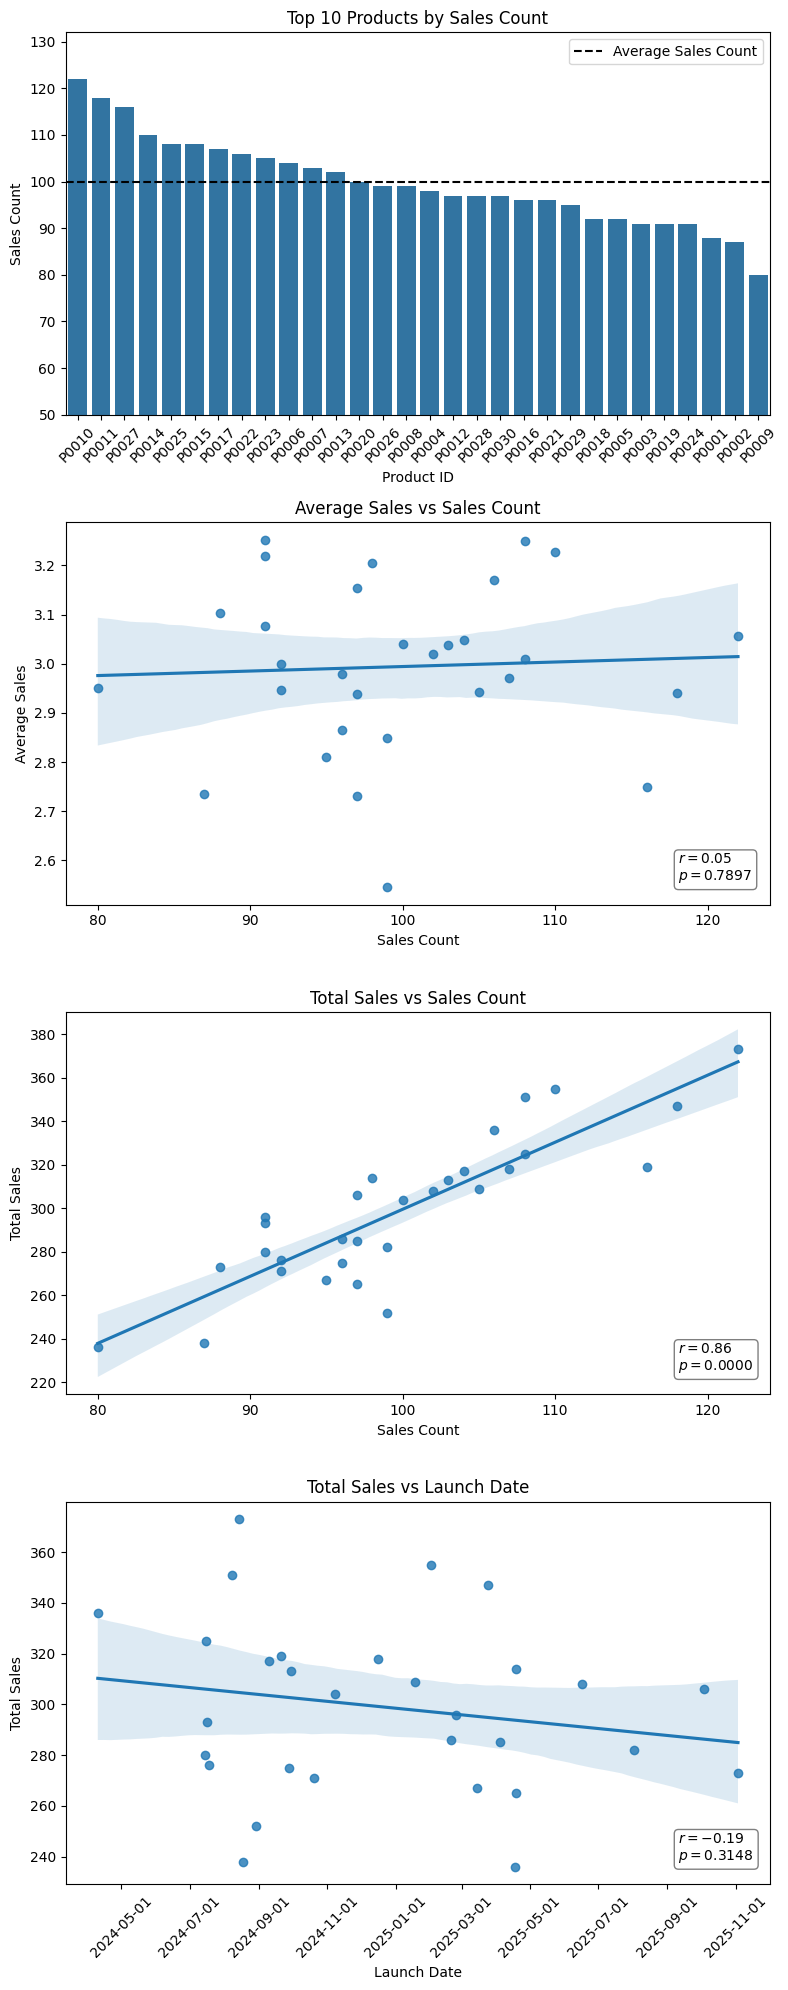

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt


# Visualize sales per product

fig, ax = plt.subplots(4, 1, figsize=(8, 20))

#  Top 10 products by sales count
sns.barplot(data=product_sales_count, x="product_id", y="count", ax=ax[0])
ax[0].set_title('Top 10 Products by Sales Count')
ax[0].set_xlabel('Product ID')
ax[0].set_ylabel('Sales Count')
ax[0].set_ylim(50, product_sales_count['count'].max() + 10)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].axhline(y=product_sales_count['count'].mean(), color='black', linestyle='--', label='Average Sales Count')
ax[0].legend()

#  Regression plots (Quantity Average and Quantity Total vs Sales Count)
sns.regplot(data=sales_stats, x="count", y="quantity_average", ax=ax[1])
ax[1].set_title('Average Sales vs Sales Count')
ax[1].set_xlabel('Sales Count')
ax[1].set_ylabel('Average Sales')
stats_text_qty_avg = f"$r = {r_value_qty_avg:.2f}$\n$p = {p_value_qty_avg:.4f}$"
ax[1].text(0.87, 0.05, stats_text_qty_avg, transform=ax[1].transAxes, 
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

sns.regplot(data=sales_stats, x="count", y="quantity_total", ax=ax[2])
ax[2].set_title('Total Sales vs Sales Count')
ax[2].set_xlabel('Sales Count') 
ax[2].set_ylabel('Total Sales')
stats_text_qty_total = f"$r = {r_value_qty_total:.2f}$\n$p = {p_value_qty_total:.4f}$"
ax[2].text(0.87, 0.05, stats_text_qty_total, transform=ax[2].transAxes, 
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


#  Regression plot (Launch Date vs Quantity Total)
sns.regplot(data=product_merged, x="date_numeric", y="quantity_total", ax=ax[3])
ax[3].set_title('Total Sales vs Launch Date')
ax[3].set_xlabel('Launch Date')
ax[3].set_ylabel('Total Sales')
ax[3].xaxis_date()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax[3].xaxis.set_major_formatter(date_format)
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)
stats_text_launch_date = f"$r = {r_value_launch_date:.2f}$\n$p = {p_value_launch_date:.4f}$"
ax[3].text(0.87, 0.05, stats_text_launch_date, transform=ax[3].transAxes, 
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


plt.tight_layout()
plt.show()